# Autoencoders

In [27]:
import numpy as np
import sys
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# Utility functions to plot grayscale images

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
    plt.axis('off')
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w + pad) * n_rows + pad, (h + pad) * n_cols + pad))
    
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y * (h + pad) + pad):(y * (h + pad) + pad + h),(x * (w + pad) + pad):(x * (w + pad) + pad + w)] = images[y * n_cols + x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

## PCA with autoencoder

### Create dummy 3D dataset

In [5]:
np.random.seed(42)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5

data = np.empty((m, 3))

data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)

# Normalize data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.fit_transform(data[100:])

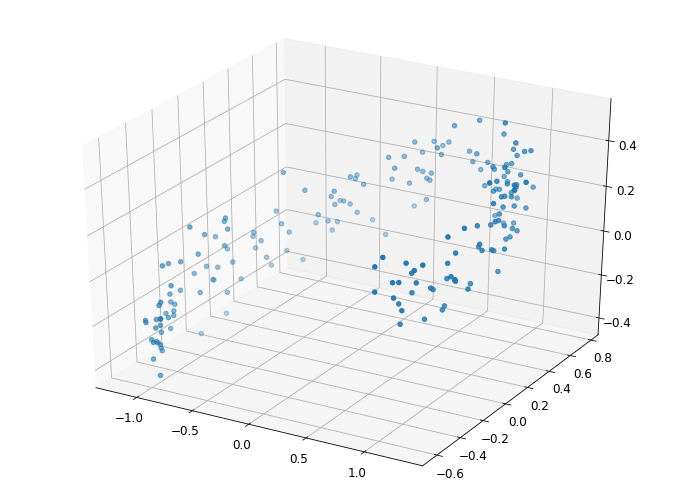

In [15]:
# Visualize 3D dataset

fig = plt.figure(figsize=[12,9])
ax = plt.axes(projection='3d')
ax.scatter3D(data[:,0], data[:,1], data[:,2]);

In [7]:
import tensorflow as tf

n_inputs = 3
n_hidden = 2
n_outputs = 3

learning_rate = 0.01

# Define architecture of autoencoder
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

# Define loss function and optimizer
loss = tf.reduce_mean(tf.square(outputs - X))
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


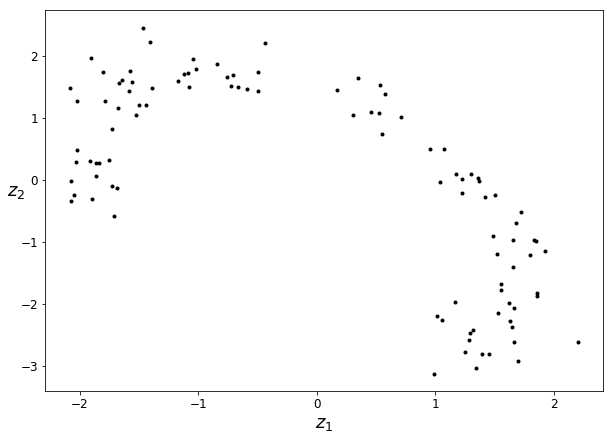

In [16]:
fig = plt.figure(figsize=[10,7])
plt.plot(codings_val[:,0], codings_val[:, 1], 'k.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.show()

## Stacked autoencoders

In [17]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('/tmp/data/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [26]:
from functools import partial

n_inputs = 28 * 28    # Required by MNIST
n_hidden1 = 300
n_hidden2 = 150       # Middle layer
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [28]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            
            sys.stdout.flush()                                          
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   
        
        print("\r{}".format(epoch), "Train MSE:", loss_train)           
        saver.save(sess, "./my_model_all_layers.ckpt") 

09% Train MSE: 0.023542223
19% Train MSE: 0.012066303
2 Train MSE: 0.011234892
3 Train MSE: 0.010532192
4 Train MSE: 0.010739449


In [32]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 3):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


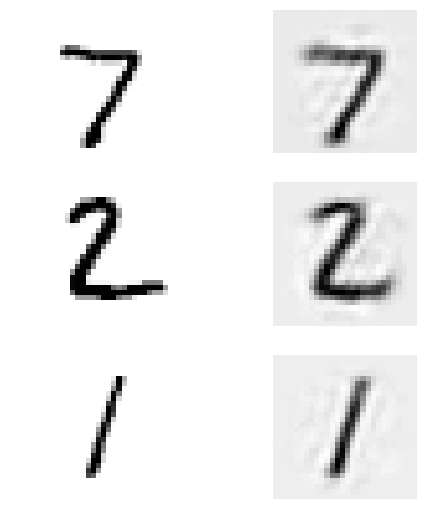

In [33]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt");

## Variational autoencoders

In [36]:
n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

eps = 1e-10    # To avoid computing log(0)

latent_loss = 0.5 * tf.reduce_sum(tf.square(hidden3_sigma) + tf.square(hidden3_mean) - 1 - tf.log(eps + tf.square(hidden3_sigma)))

loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [37]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 31521.977 	Reconstruction loss: 24244.09 	Latent loss: 7277.887
1 Train total loss: 27603.04 	Reconstruction loss: 22578.408 	Latent loss: 5024.631
2 Train total loss: 29213.357 	Reconstruction loss: 23616.145 	Latent loss: 5597.213
3 Train total loss: 25057.21 	Reconstruction loss: 21135.904 	Latent loss: 3921.3062
49% Train total loss: 21982.365 	Reconstruction loss: 18717.115 	Latent loss: 3265.25
59% Train total loss: 21811.43 	Reconstruction loss: 18148.94 	Latent loss: 3662.4897
6 Train total loss: 18354.352 	Reconstruction loss: 15275.652 	Latent loss: 3078.6987
79% Train total loss: 17065.855 	Reconstruction loss: 13983.918 	Latent loss: 3081.9365
8 Train total loss: 16643.035 	Reconstruction loss: 13472.028 	Latent loss: 3171.007
9 Train total loss: 16789.73 	Reconstruction loss: 13517.814 	Latent loss: 3271.915
10 Train total loss: 17555.719 	Reconstruction loss: 14113.305 	Latent loss: 3442.4133
11 Train total loss: 17141.027 	Reconstruction loss: 13778.1

### Generate digits with variational autoencoder

In [38]:
n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            sys.stdout.flush()                                          
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) 
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 35820.79 	Reconstruction loss: 26312.957 	Latent loss: 9507.834
1 Train total loss: 31945.342 	Reconstruction loss: 26925.496 	Latent loss: 5019.8457
29% Train total loss: 28980.3 	Reconstruction loss: 23939.766 	Latent loss: 5040.536
3 Train total loss: 31723.953 	Reconstruction loss: 25633.848 	Latent loss: 6090.1064
4 Train total loss: 26433.553 	Reconstruction loss: 22694.527 	Latent loss: 3739.025
5 Train total loss: 23363.916 	Reconstruction loss: 19511.217 	Latent loss: 3852.6992
6 Train total loss: 19446.102 	Reconstruction loss: 16531.04 	Latent loss: 2915.063
7 Train total loss: 18321.096 	Reconstruction loss: 15310.957 	Latent loss: 3010.1394
8 Train total loss: 17944.44 	Reconstruction loss: 14861.577 	Latent loss: 3082.8618
9 Train total loss: 17627.16 	Reconstruction loss: 14519.977 	Latent loss: 3107.1846
10 Train total loss: 16613.11 	Reconstruction loss: 13405.726 	Latent loss: 3207.3845
11 Train total loss: 16400.336 	Reconstruction loss: 13313.713

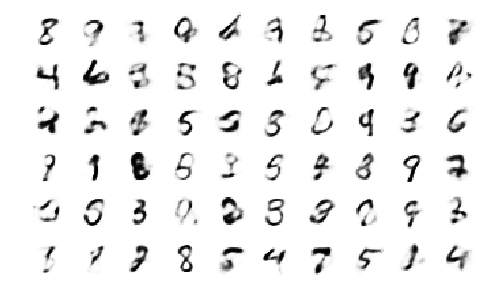

In [39]:
plt.figure(figsize=(8,50)) 
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])